# **Feature map experiments on an MNIST GAN**

# Setup

In [ ]:
# Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/ECE 209AS Bake-off #2/pytorch-mnist-GAN')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import copy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [ ]:
class GeneratorFCBlock(nn.Module):
  def __init__(self, g_input_dim, g_output_dim):
    super(GeneratorFCBlock, self).__init__()
    output_dim = 1
    for dim in g_output_dim[1:]:
      output_dim *= dim
    self.g_output_dim = g_output_dim
    self.fc = nn.Linear(g_input_dim, output_dim)
    self.bn = nn.BatchNorm2d(g_output_dim[1])
    self.act = nn.LeakyReLU(0.2)
  def forward(self, x):
    x = self.fc(x).view(self.g_output_dim)
    x = self.bn(x)
    return self.act(x)

In [ ]:
class GeneratorConvBlock(nn.Module):
  def __init__(self, g_input_dim, g_output_dim, stride, padding, output_padding, activation="leaky_relu"):
    super(GeneratorConvBlock, self).__init__()
    self.conv = nn.ConvTranspose2d(g_input_dim, g_output_dim, kernel_size=(5,5), stride=stride, padding=padding, output_padding=output_padding)
    self.bn = None if activation == "tanh" else nn.BatchNorm2d(g_output_dim)
    if activation == "leaky_relu":
      self.act = nn.LeakyReLU(0.2)
    elif activation == "tanh":
      self.act = nn.Tanh()
    self.activation = activation
  def forward(self, x):
    x = self.conv(x)
    if self.bn:
      x = self.bn(x)
    x = self.act(x)
    return x

In [ ]:
z_dim = 5
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G_layer_defs = [(z_dim, (-1, 256, 7, 7)), (256, 128, 1, 2, 0, "leaky_relu"), (128, 64, 2, 2, 1, "leaky_relu"), (64, 1, 2, 2, 1, "tanh")]
G_layers = []
for layer_def in G_layer_defs:
  if len(layer_def) == 2:
    input_dim, output_dim = layer_def
    G_layers.append(GeneratorFCBlock(input_dim, output_dim).to(device))
  else:
    input_dim, output_dim, stride, padding, output_padding, act = layer_def
    G_layers.append(GeneratorConvBlock(input_dim, output_dim, stride, padding, output_padding, act).to(device))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
def load_model(model, filepath):
  state = torch.load(filepath)
  model.load_state_dict(state['state_dict'])

In [ ]:
for idx, layer in enumerate(G_layers):
  load_model(layer, "models/g_layer_{}".format(idx))

# Digit exploration

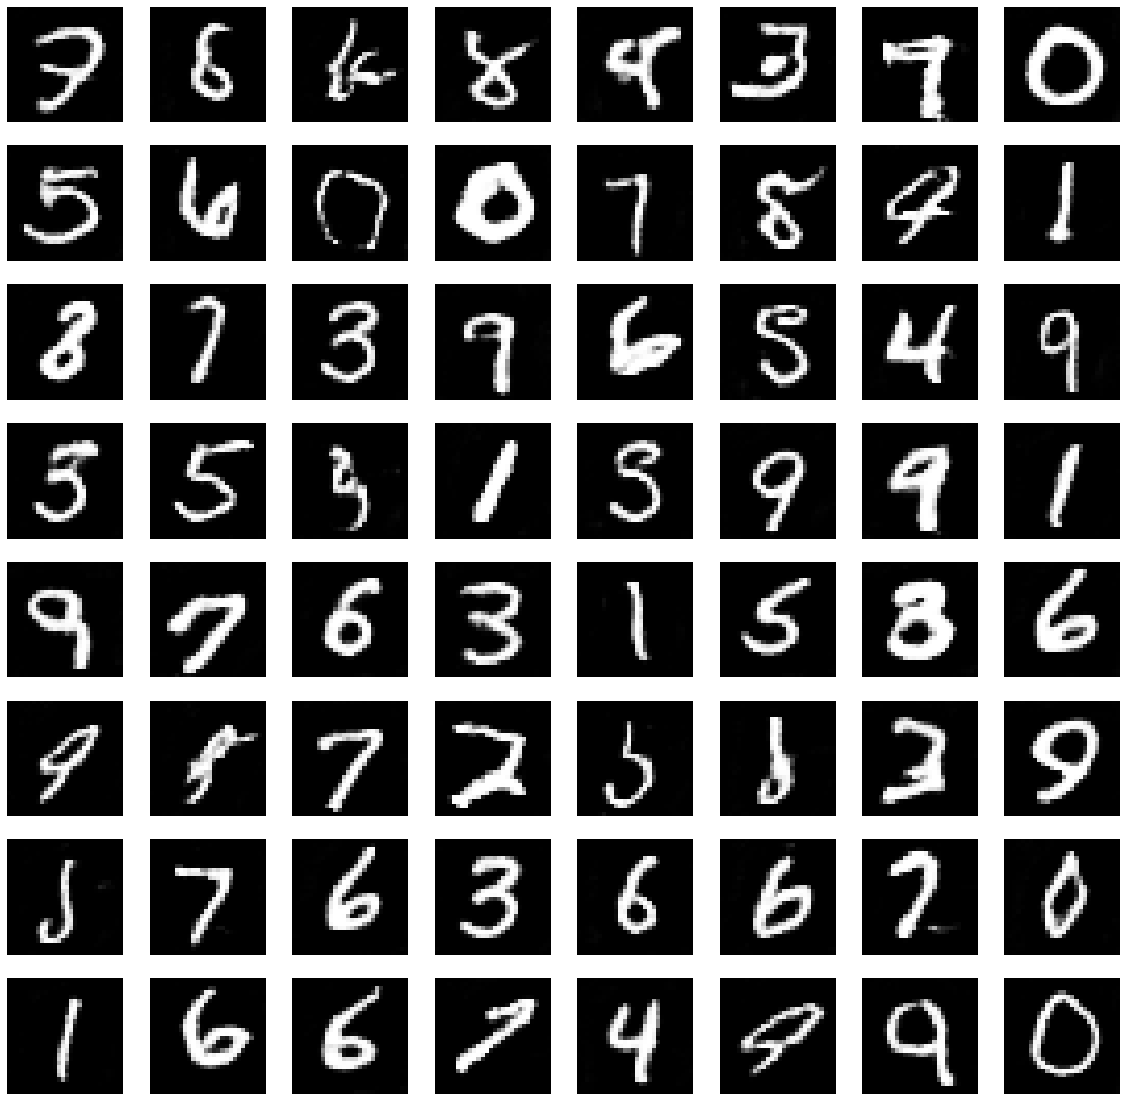

In [ ]:
a = torch.randn(64, 5)
z = a.to(device)
for layer in G_layers:
  z = layer(z)
z = z.to("cpu").detach().numpy()
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20,20))
for i in range(8):
  for j in range(8):
    axes[i][j].imshow(z[8 * i + j, 0, :, :], cmap="gray")
    axes[i][j].set_axis_off()

# Helper methods

In [ ]:
def plot(nums):
  fig, axes = plt.subplots(nrows=1, ncols=len(nums), figsize=(20,20))
  for i in range(len(nums)):
    z = nums[i].to(device)
    for layer in G_layers:
      z = layer(z)
    z = z.cpu().detach().numpy()
    axes[i].imshow(z[0, 0, :, :], cmap="gray")
    axes[i].set_axis_off()
  plt.show()

In [ ]:
def z_to_maps(z):
  # z = torch.tensor(z).to(device)
  for layer in G_layers:
    z = layer(z)
    if layer == G_layers[-3]:
      return z.cpu().detach().numpy()
  return z.cpu().detach().numpy()

In [ ]:
def maps_to_img(maps):
  z = torch.from_numpy(maps).to(device)
  for layer in G_layers[-2:]:
    z = layer(z)
  return z.cpu().detach().numpy()[0, 0, :, :]

In [ ]:
# Greedily find feature maps that change the shape the most
def find_morph_maps(maps1, maps2, num_filters, min_change=False):
  idxs = []
  remaining = list(range(128))
  maps1_curr = maps1.copy()
  img_orig = maps_to_img(maps1)
  for _ in range(num_filters):
    diff = []
    for i in remaining:
      maps1_new = maps1_curr.copy()
      maps1_new[0, i] = maps2[0, i]
      img_new = maps_to_img(maps1_new)
      diff.append(((img_new - img_orig)**2).mean())

    if min_change:
      rem_idx = np.argmin(diff)
    else:
      rem_idx = np.argmax(diff)

    # print(remaining[rem_idx])
    map_idx = remaining.pop(rem_idx)
    idxs.append(map_idx)
    maps1_curr[0, map_idx] = maps2[0, map_idx]
    #print(np.argsort(diff))
    #print(((maps1_curr - maps1)**2).mean())

  return idxs

# **Main Section**

## Digits in latent space

*   5 samples each



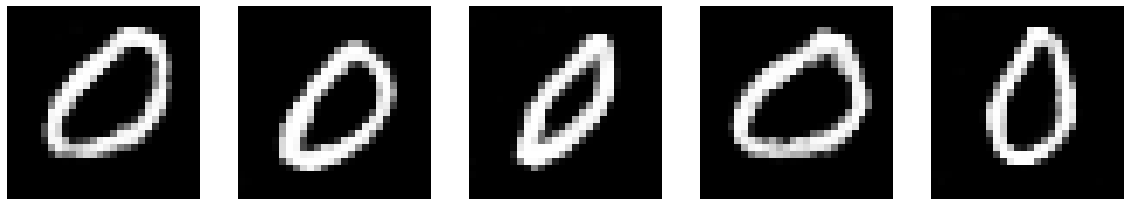

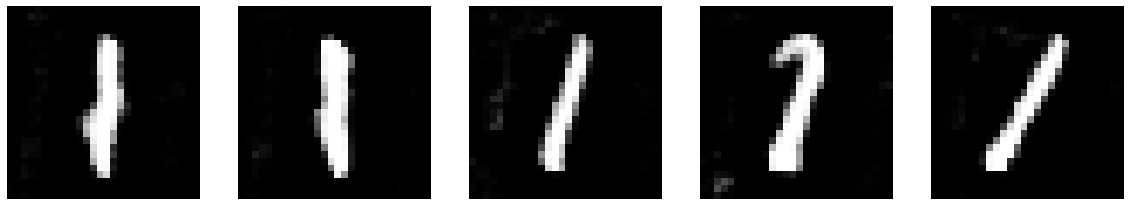

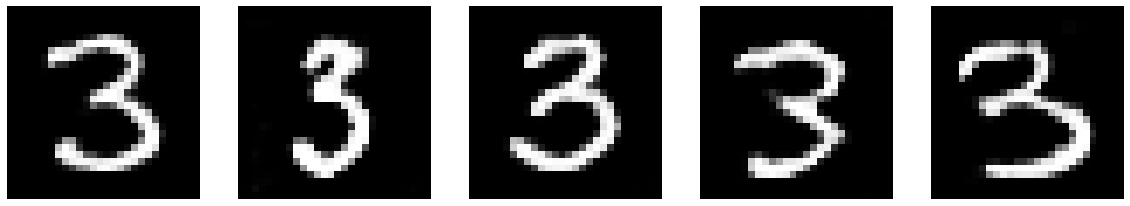

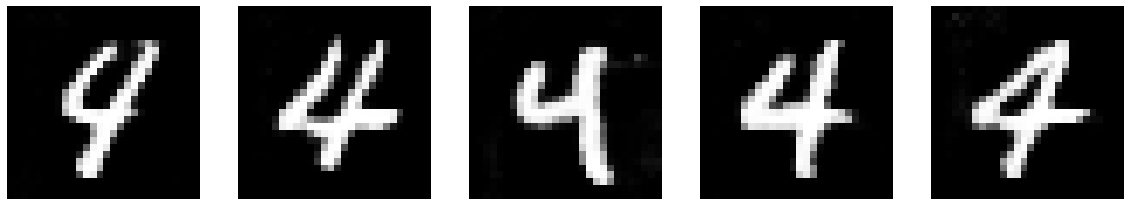

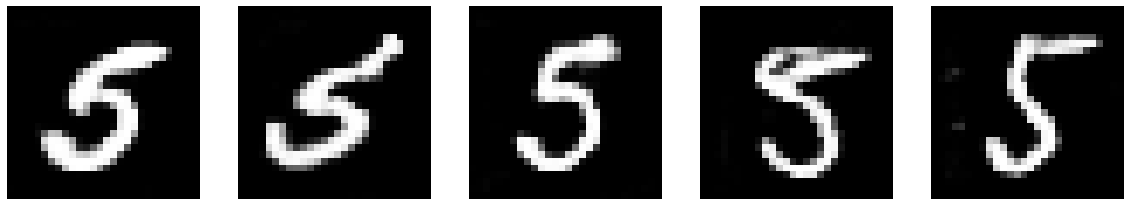

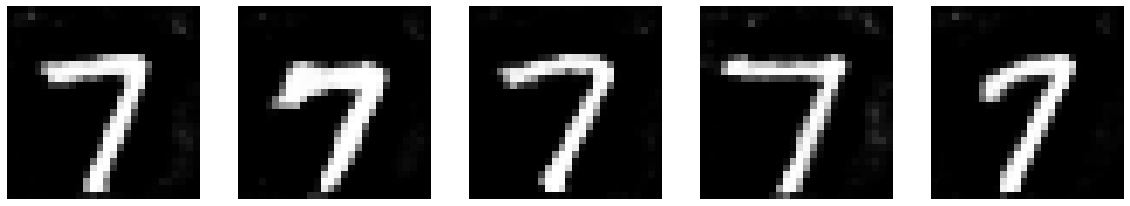

In [23]:
zeros = torch.tensor([[-1.7950, -0.7191, -1.6293, -0.5353, -0.3919],
        [-0.0072,  0.0749, -1.4635,  0.0919, -0.2612],
        [-0.6942,  0.4471, -1.0372, -0.3392, -0.5470],
        [-1.0571, -1.5198, -2.1378, -0.7594, -0.9022],
        [-0.8340, -0.0132, -0.8453,  0.7948, -0.4284]]).to(device)

ones = torch.tensor([[ 0.1785,  1.2583,  0.0501,  0.6782, -0.1833],
        [ 0.3692,  0.9957,  0.4225,  1.0019, -0.0645],
        [-0.1663,  1.7839,  0.6865, -0.5465, -0.3940],
        [ 0.2931,  0.3683,  0.6057, -0.2477, -0.1636],
        [-0.4751,  0.9655,  0.7890, -1.1732, -0.4091]]).to(device)

threes = torch.tensor([[ 0.3420, -1.7319,  0.7826, -0.0266,  0.0961],
        [ 1.1422, -0.0147,  0.6884,  0.3195, -0.2327],
        [ 0.9559, -1.2987,  0.2798, -0.1502, -0.2525],
        [-0.3569, -1.3723,  0.6721, -0.3472,  1.0787],
        [ 1.3665, -1.6100,  0.5246,  0.8087,  1.0849]]).to(device)

fours = torch.tensor([[-1.2684,  0.4150,  0.0659,  0.2181,  0.1513],
        [-1.8444,  1.1473, -0.5340,  0.9594, -0.3469],
        [-0.1197,  0.5008,  0.9204,  1.6548,  1.4618],
        [-1.5614,  1.2049, -0.4815,  1.1166,  0.9855],
        [-1.7293,  1.9704, -0.6565,  0.2414,  0.0409]]).to(device)

fives = torch.tensor([[ 0.9086, -0.0361, -0.5575, -0.3666, -0.4778],
        [ 1.0626,  0.4781, -1.4853, -1.1458, -1.4364],
        [ 0.9709, -0.2559,  0.3109,  0.0248, -0.6975],
        [ 0.7165, -0.3613,  1.8990,  0.9626, -0.0036],
        [ 1.6248,  0.7639,  0.4735,  0.8745, -1.0194]]).to(device)

sevens = torch.tensor([[ 0.4152,  0.2758,  0.1154, -0.7154,  1.0423],
        [ 1.2073,  0.3083, -0.7147, -0.3508,  0.9183],
        [-0.0915, -0.1583,  0.3360, -0.7461,  1.3491],
        [ 0.8540,  0.8254,  0.1625, -1.6405,  1.8165],
        [-0.0247,  0.6392, -0.3730, -0.6873,  0.8334]]).to(device)

plot(zeros)
plot(ones)
plot(threes)
plot(fours)
plot(fives)
plot(sevens)

digit_pairs = [(zeros, fours), (ones, threes), (fives, sevens)]

## Determining representative feature maps

For each digit pair (say, 0-4):


*   For each pair of corresponding digit samples (e.g., first 0 and first 4):
  * Find 64 feature maps that cause the most change in the final output when swapped
  * Put indices of feature maps into a list ("idxs")
* Take the intersection of all five index lists







In [ ]:
idx_ints = []
for num1_list, num2_list in digit_pairs:
  idxs_list = []
  for num1, num2 in zip(num1_list, num2_list):
    maps1 = z_to_maps(num1)
    maps2 = z_to_maps(num2)
    idx_set = set(find_morph_maps(maps1, maps2, 64))
    idxs_list.append(idx_set)

  idx_int = list(set.intersection(*idxs_list))
  idx_ints.append(idx_int)

for idx_int in idx_ints:
  print(idx_int)

[0, 97, 3, 35, 5, 99, 101, 106, 43, 76, 47, 112, 82, 52, 21, 54, 87, 120, 29]
[0, 3, 12, 18, 19, 32, 43, 48, 52, 56, 76, 82, 87, 88, 95, 99, 101, 105, 111, 114, 115, 126]
[0, 1, 97, 101, 5, 43, 76, 107, 47, 48, 49, 82, 19, 52, 95]


## Plot morphed digits

In [ ]:
def plot_morphed_digits(num1_list, num2_list, map_idxs, zeroed_maps=False):
  img_rows = []
  for num1, num2 in zip(num1_list, num2_list):
    maps1 = z_to_maps(num1)
    maps2 = z_to_maps(num2)

    maps1_new = maps1.copy()
    if zeroed_maps:
      maps1_new[0, map_idxs] = 0
    else:
      maps1_new[0, map_idxs] = maps2[0, map_idxs]
      
    img_rows.append(list(map(maps_to_img, [maps1, maps1_new, maps2])))

  fig, axes = plt.subplots(nrows=len(img_rows), ncols=len(img_rows[0]), figsize=(10, 10))
  for i, img_row in enumerate(img_rows):
    for j, img in enumerate(img_row):
      axes[i][j].imshow(img, cmap="gray")
      axes[i][j].set_axis_off()

  plt.show()

### 0 and 4

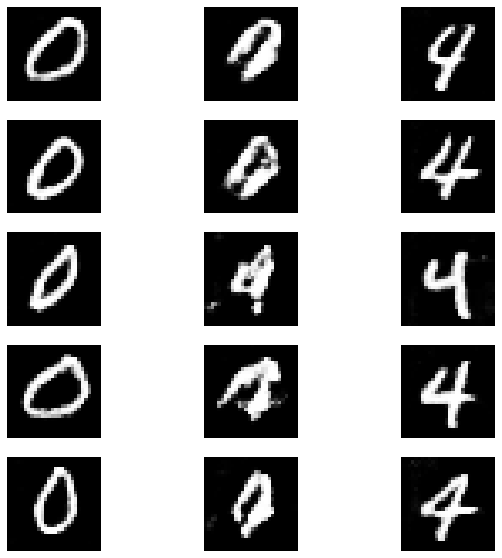

In [ ]:
plot_morphed_digits(*digit_pairs[0], idx_ints[0])

### 1 and 3

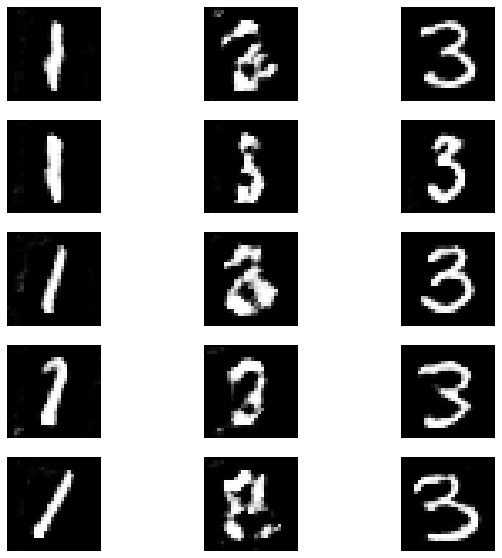

In [ ]:
plot_morphed_digits(*digit_pairs[1], idx_ints[1])

### 5 and 7

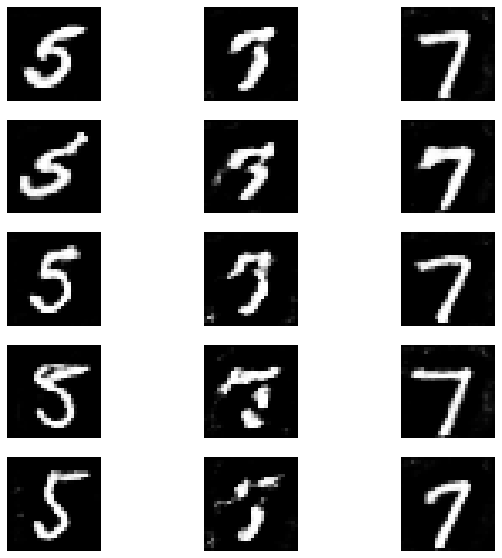

In [ ]:
plot_morphed_digits(*digit_pairs[2], idx_ints[2])

#Experiment 1: Morph one number into another number by swapping feature maps

In [ ]:
def swap_maps(z1, z2, layer_idx, num_swap):
  z1, z2 = z1.to(device), z2.to(device)
  for idx, layer in enumerate(G_layers):
    z1 = layer(z1)
    z2 = layer(z2)
    if idx == layer_idx - 1:
      ref_maps1 = z1.cpu().detach().numpy()
      ref_maps2 = z2.cpu().detach().numpy()
  z1 = z1.cpu().detach().numpy()
  z2 = z2.cpu().detach().numpy()
  _, num_filters, _, _ = ref_maps1.shape
  feature_idxs = np.random.permutation(num_filters)[:num_swap]
  maps1 = copy.deepcopy(ref_maps1)
  maps1[0, feature_idxs] = ref_maps2[0, feature_idxs]
  z = torch.from_numpy(maps1).to(device)
  for layer in G_layers[layer_idx:]:
    z = layer(z)
  z = z.cpu().detach().numpy()
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
  axes[0].imshow(z1[0, 0, :, :], cmap="gray")
  axes[0].set_axis_off()
  axes[1].imshow(z2[0, 0, :, :], cmap="gray")
  axes[1].set_axis_off()
  axes[2].imshow(z[0, 0, :, :], cmap="gray")
  axes[2].set_axis_off()

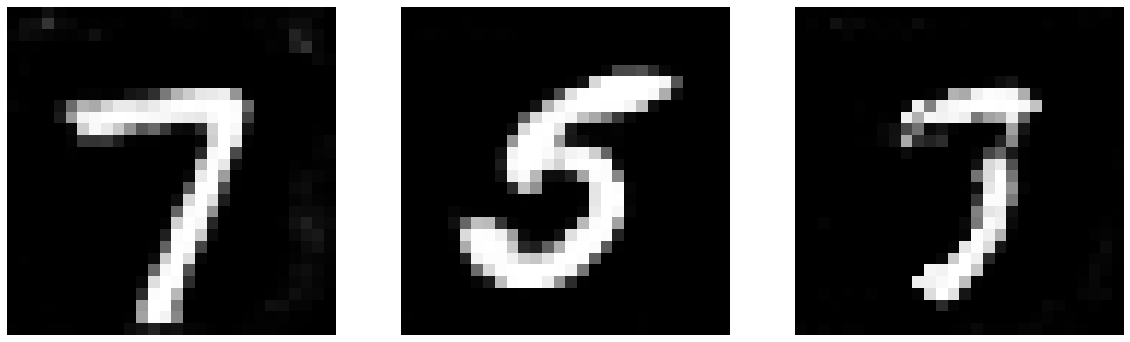

In [ ]:
swap_maps(sevens[0], fives[0], 3, 25)

In [ ]:
def swap_maps_prog(z1, z2, layer_idx, num_progression):
  z1, z2 = z1.to(device), z2.to(device)
  for idx, layer in enumerate(G_layers[:layer_idx]):
    z1 = layer(z1)
    z2 = layer(z2)
    if idx == layer_idx - 1:
      ref_maps1 = z1.cpu().detach().numpy()
      ref_maps2 = z2.cpu().detach().numpy()
  _, num_filters, _, _ = ref_maps1.shape
  fig, axes = plt.subplots(nrows=1, ncols=num_progression + 1, figsize=(20,20))
  for prog in range(num_progression + 1):
    num_swap = prog * num_filters // num_progression
    feature_idxs = np.arange(num_filters)
    np.random.shuffle(feature_idxs)
    feature_idxs = feature_idxs[:num_swap]
    maps1 = copy.deepcopy(ref_maps1)
    maps1[0, feature_idxs] = ref_maps2[0, feature_idxs]
    z = torch.from_numpy(maps1).to(device)
    for layer in G_layers[layer_idx:]:
      z = layer(z)
    z = z.cpu().detach().numpy()
    axes[prog].imshow(z[0, 0, :, :], cmap="gray")
    axes[prog].set_axis_off()
    axes[prog].set_title("{}% swapped".format(prog/num_progression * 100))

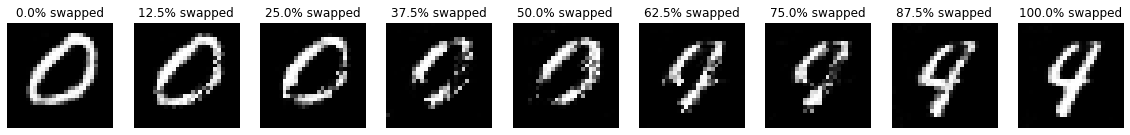

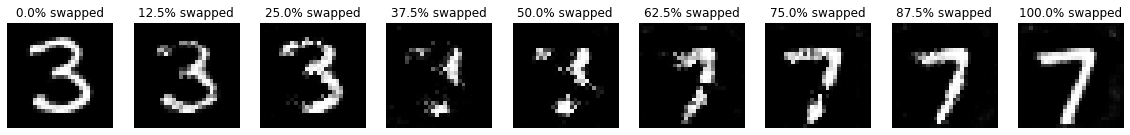

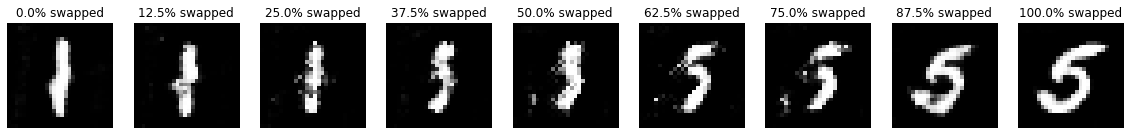

In [ ]:
swap_maps_prog(zeros[0], fours[0], 3, 8)
swap_maps_prog(threes[0], sevens[0], 3, 8)
swap_maps_prog(ones[0], fives[0], 3, 8)


# Experiment 2: Morph a 1 into a 3 by swapping a few feature maps

In [ ]:
maps1 = z_to_maps(ones[0])
maps2 = z_to_maps(threes[0])

idxs = find_morph_maps(maps1, maps2, 20)
print(idxs)

maps1_new = maps1.copy()
maps1_new[0, idxs] = maps2[0, idxs]

[44, 23, 0, 125, 83, 126, 47, 76, 41, 67, 19, 82, 101, 3, 52, 43, 18, 48, 9, 33]


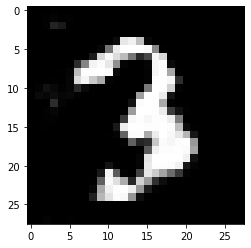

In [ ]:
z = torch.from_numpy(maps1_new).to(device)
for layer in G_layers[-2:]:
  z = layer(z)
z = z.cpu().detach().numpy()
plt.imshow(z[0, 0, :, :], cmap="gray")

In [ ]:
# Repeat with another 1-3 pair
maps1 = z_to_maps(ones[1])
maps2 = z_to_maps(threes[1])

idxs = find_morph_maps(maps1, maps2, 20)
print(idxs)

[101, 5, 126, 19, 48, 41, 3, 52, 43, 18, 116, 76, 95, 88, 83, 105, 114, 12, 82, 99]


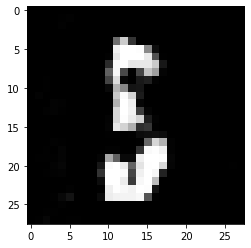

In [ ]:
maps1_new = maps1.copy()
maps1_new[0, idxs] = maps2[0, idxs]

z = torch.from_numpy(maps1_new).to(device)
for layer in G_layers[-2:]:
  z = layer(z)
z = z.cpu().detach().numpy()
plt.imshow(z[0, 0, :, :], cmap="gray")

# Experiment 3: Swap as many feature maps as possible while minimizing morphing

In [ ]:
# Try modifying as many feature maps as possible without changing the shape
maps1 = z_to_maps(ones[0])
maps2 = z_to_maps(threes[0])

idxs = find_morph_maps(maps1, maps2, 100, min_change=True)
print(idxs)

[118, 6, 123, 93, 4, 92, 55, 21, 40, 73, 87, 2, 38, 94, 14, 36, 103, 110, 63, 62, 74, 54, 127, 10, 16, 8, 22, 124, 79, 68, 57, 58, 100, 49, 104, 26, 33, 20, 121, 46, 15, 89, 98, 77, 13, 72, 81, 24, 25, 50, 12, 7, 42, 64, 86, 82, 34, 122, 51, 75, 117, 85, 30, 29, 119, 80, 102, 11, 78, 105, 53, 66, 91, 59, 115, 32, 37, 120, 126, 18, 106, 71, 116, 96, 45, 9, 28, 69, 1, 35, 109, 61, 3, 125, 39, 97, 108, 112, 56, 65]


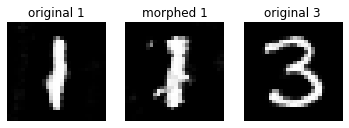

In [ ]:
# Compare original and morphed images
maps1_new = maps1.copy()
maps1_new[0, idxs] = maps2[0, idxs]

title_list = ['original 1', 'morphed 1', 'original 3']
map_list = [maps1, maps1_new, maps2]
img_list = list(map(maps_to_img, map_list))

for i, (img, title) in enumerate(zip(img_list, title_list)):
  plt.subplot(1, len(img_list), i + 1)
  plt.imshow(img, cmap="gray")
  plt.title(title)
  plt.axis('off')

# Experiment 4: Do different samples from the same digit pair share the same representative feature maps?

[44, 23, 0, 125, 83, 126, 47, 76, 41, 67, 19, 82, 101, 3, 52]


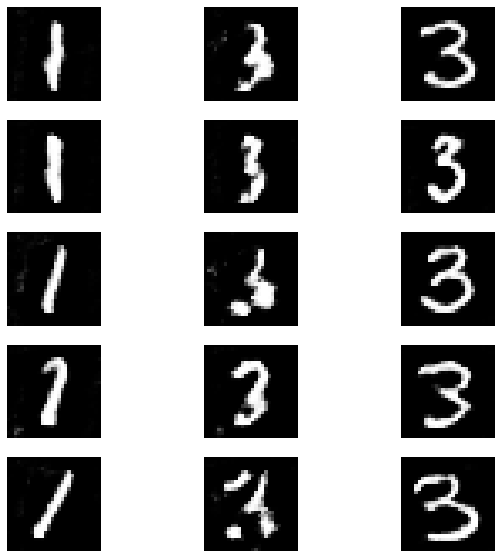

In [ ]:
# Can we swap the same features on other pairs and get the same results?
maps1 = z_to_maps(ones[0])
maps2 = z_to_maps(threes[0])

idxs = find_morph_maps(maps1, maps2, 15)
print(idxs)

plot_morphed_digits(ones, threes, idxs)

# Experiment 5: Attempts at ablating filters

In [ ]:
def plot_num_and_features(z):
  for layer in G_layers:
    z = layer(z)
    if layer == G_layers[-2]:
      maps1 = z.cpu().detach().numpy()
  z = z.cpu().detach().numpy()
  plt.imshow(z[0, 0, :, :], cmap="gray")
  plt.axis("off")
  ref_maps1 = copy.deepcopy(maps1)
  fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20,20))
  for i in range(8):
    for j in range(8):
      axes[i][j].imshow(maps1[0, 8 * i + j, :, :], cmap="gray")
      axes[i][j].set_axis_off()
  plt.show()

In [ ]:
def ablate_filter(layer, idxs):
  new_layer = copy.deepcopy(layer)
  for name, param in new_layer.named_parameters():
    if name == "conv.weight":
      for idx in idxs:
        param[:, idx, :, :] = torch.zeros_like(param[:, 0, :, :])
  return new_layer

In [ ]:
def swap_and_ablate(z1, z2, layer_idx, filter_idxs, num_feature_swap):
  z1, z2 = z1.to(device), z2.to(device)
  for idx, layer in enumerate(G_layers):
    if idx == layer_idx - 1:
      _, num_filters, _, _ = z1.size()
      feature_idxs = np.random.permutation(num_filters)[:num_feature_swap]
      z1[0, feature_idxs] = z2[0, feature_idxs]
      z2 = layer(z2)
      new_layer = ablate_filter(layer, filter_idxs)
      z1 = new_layer(z1)
      maps1 = z1.cpu().detach().numpy()
    else:
      z1 = layer(z1)
      z2 = layer(z2)
  z = z1.cpu().detach().numpy()
  plt.imshow(z[0, 0, :, :], cmap="gray")
  plt.axis("off")
  plt.show()
  fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20,20))
  for i in range(8):
    for j in range(8):
      axes[i][j].imshow(maps1[0, 8 * i + j, :, :], cmap="gray")
      axes[i][j].set_axis_off()
  plt.show()

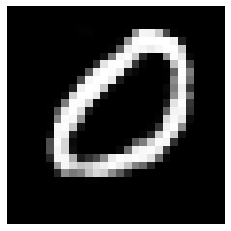

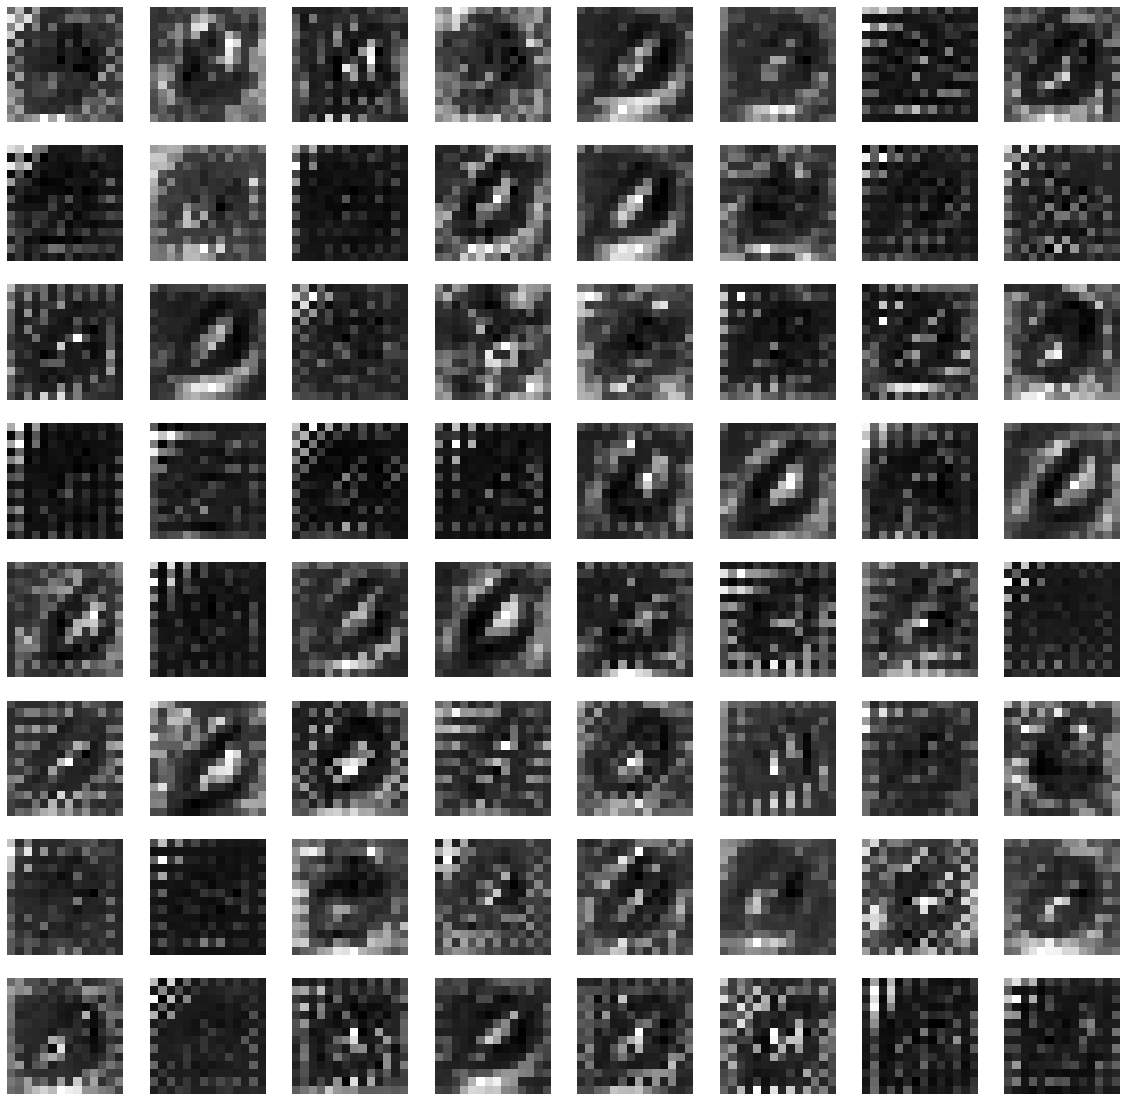

In [ ]:
plot_num_and_features(zeros[0])

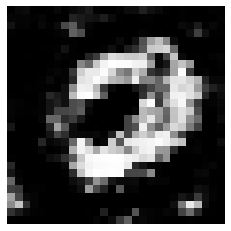

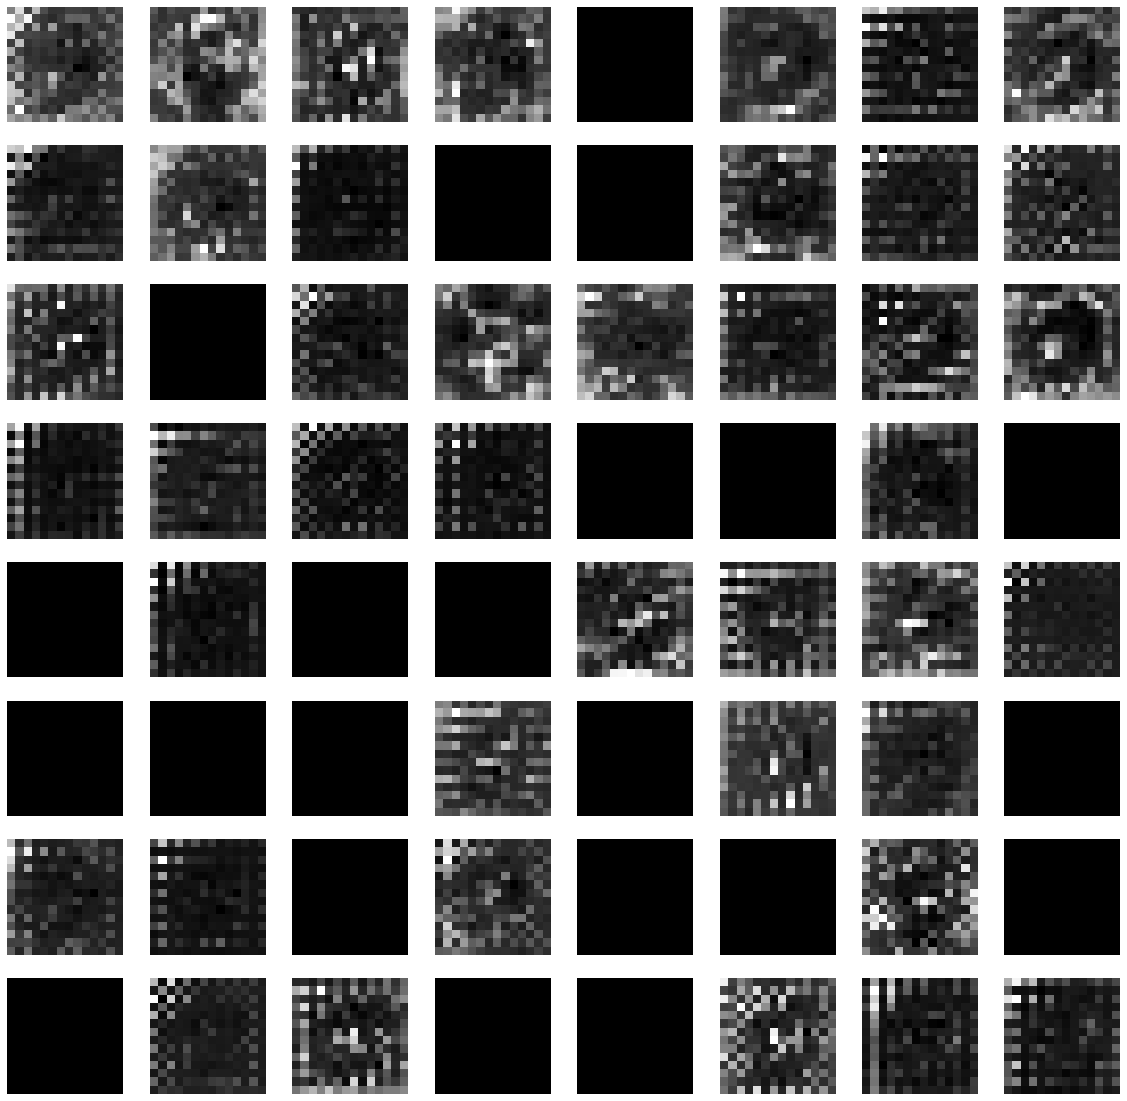

In [ ]:
zeros_idxs = [4, 11, 12, 17, 28, 29, 31, 32, 34, 35, 40, 41, 42, 44, 47, 50, 52, 53, 55, 56, 59, 60]
swap_and_ablate(zeros[0], sevens[0], 3, zeros_idxs, 25)

#Appendix

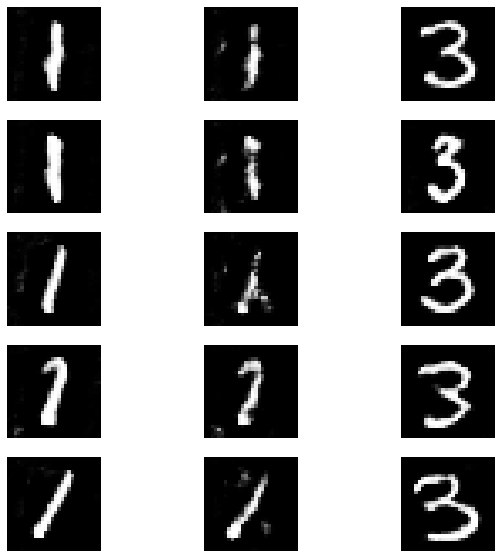

In [ ]:
# What happens if we turn off those feature maps?
plot_morphed_digits(ones, threes, idxs, zeroed_maps=True)

## Experiment 5a: Can a cross on a 7 be explained by a few filters?

In [ ]:
crossed_sevens = torch.tensor([[-1.5461, -1.8621, -0.4421, -0.5492,  2.1665],
                               [-1.2073, -1.1942, -0.1012,  0.1447,  1.7323],
                               [-0.0074, -0.9136,  0.0625, -0.3600,  1.6037],
                               [-1.1769, -1.1267, -0.8809, -0.9887,  1.6702],
                               [-0.3545, -0.4838,  1.0084, -0.3014,  2.7598],
                               [-0.7681, -1.0257,  0.1989, -0.1410,  1.9639],
                               [-1.1975, -1.1058,  0.3000, -0.7135,  1.7818]]).to(device)

[76, 117, 0, 52, 81, 43, 107, 41, 101, 9, 7, 85, 82, 106, 93, 18, 67, 116, 113, 6]


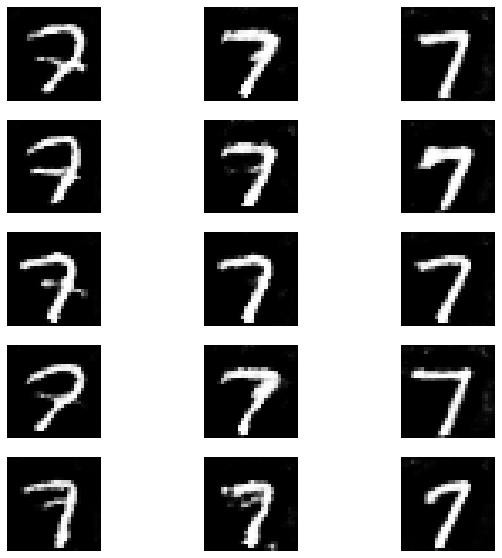

In [ ]:
# Repeat for crossed 7s
maps1 = z_to_maps(crossed_sevens[0])
maps2 = z_to_maps(sevens[0])

idxs = find_morph_maps(maps1, maps2, 20)
print(idxs)

plot_morphed_digits(crossed_sevens, sevens, idxs)

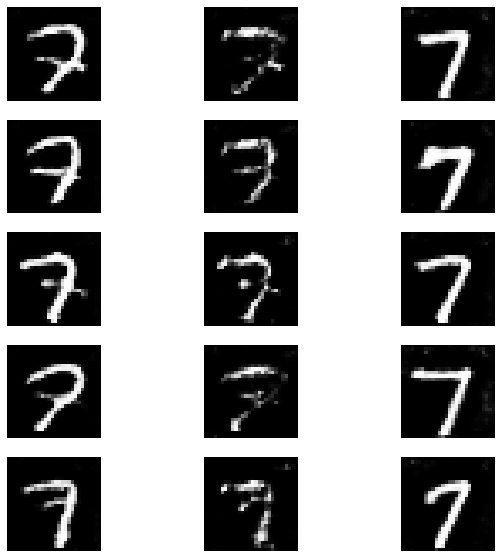

In [ ]:
# Ablate filters to make cross disappear from 7
plot_morphed_digits(crossed_sevens, sevens, idxs, zeroed_maps=True)

[107, 76, 106, 85, 81, 5, 117, 82, 18, 9, 0, 3, 93, 36, 43, 7, 54, 90, 83, 86, 42, 52, 105, 56, 95, 84, 87, 66, 41, 2, 31, 35, 48, 27, 109, 116, 14, 97, 101, 37, 71, 69, 108, 44, 79, 58, 6, 47, 23, 91, 78, 26, 114, 25, 62, 100, 30, 22, 29, 80, 8, 16, 102, 70]


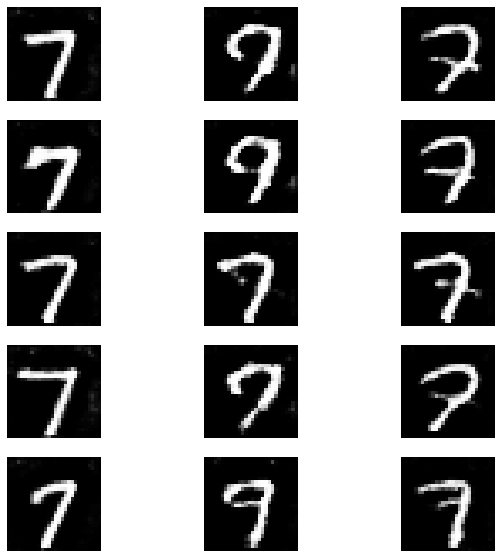

In [ ]:
# Didn't work, how about adding a cross to 7?
maps1 = z_to_maps(sevens[0])
maps2 = z_to_maps(crossed_sevens[0])

idxs = find_morph_maps(maps1, maps2, 64)
print(idxs)

plot_morphed_digits(sevens, crossed_sevens, idxs)

In [ ]:
# Not good, change error function to difference from 2nd picture
def find_morph_maps2(maps1, maps2, num_filters, min_change=False):
  idxs = []
  remaining = list(range(128))
  maps1_curr = maps1.copy()
  img_orig = maps_to_img(maps2)
  for _ in range(num_filters):
    diff = []
    for i in remaining:
      maps1_new = maps1_curr.copy()
      maps1_new[0, i] = maps2[0, i]
      img_new = maps_to_img(maps1_new)
      diff.append(((img_new - img_orig)**2).mean())

    if min_change:
      rem_idx = np.argmax(diff)
    else:
      rem_idx = np.argmin(diff)

    map_idx = remaining.pop(rem_idx)
    idxs.append(map_idx)
    maps1_curr[0, map_idx] = maps2[0, map_idx]

  return idxs

[107, 76, 85, 113, 81, 32, 43, 0, 106, 117, 6, 52, 7, 125, 72, 110, 95, 9, 90, 67, 82, 93, 116, 18, 41, 101, 48, 97, 42, 44, 27, 120, 86, 70, 109, 87, 63, 75, 37, 4, 84, 17, 26, 104, 40, 69, 102, 79, 64, 28, 25, 57, 3, 34, 38, 19, 10, 123, 33, 94, 30, 15, 62, 74]


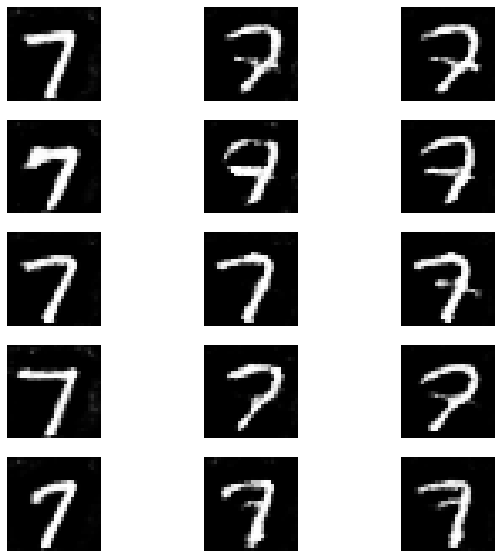

In [ ]:
# Try again
maps1 = z_to_maps(sevens[0])
maps2 = z_to_maps(crossed_sevens[0])

idxs = find_morph_maps2(maps1, maps2, 64)
print(idxs)

plot_morphed_digits(sevens, crossed_sevens, idxs)

## Experiment 5b: Attempt to cross a 1 using a crossed 7's feature maps


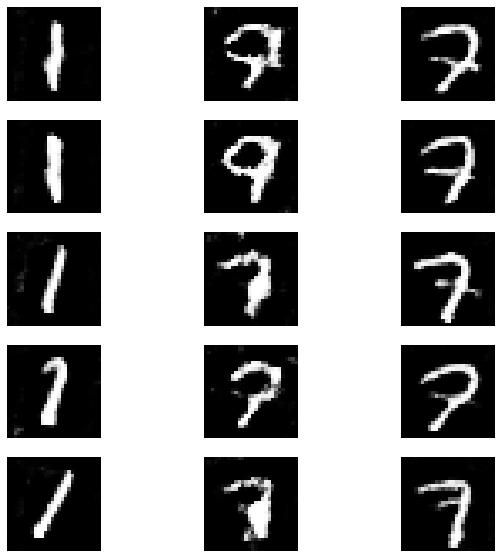

In [ ]:
# Try crossing 1s
plot_morphed_digits(ones, crossed_sevens, idxs)

In [ ]:
# Instead of crossed 1s, we get 7s :/